# In this notebook
I look at the relationship between the station intensity and income.

I also find that we can totally use the neighboring census tracts to get a reasonable income level to use for analysis.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from matplotlib import pyplot as plt

import pymc as pm
import arviz as az

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_75648/2087585347.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
# This code loads the census tract shapefile for Durham County
tracts = gpd.read_file('../data/raw/census/tl_2020_37063_tract20/tl_2020_37063_tract20.shp')

In [18]:
print(len(tracts))

68


In [19]:
# This code loads the median household income for Durham county
income = pd.read_excel('../data/raw/census/acs_median_income.xlsx', header=1)
income['tract'] = income['Geography'].str.split('US').str[1]
# Extract the tracts that begin with 37063 (Durham)
income = income.loc[income['tract'].str.contains(r'^37063\d.')]
print(len(income))

68


In [20]:
# This code loads the population for Durham county
population = pd.read_csv("../data/raw/census/ACSDP5Y2020.DP05-Data.csv", header=1)
population = population[['Geography','Estimate!!SEX AND AGE!!Total population']]
population['tract'] = population['Geography'].str.split('US').str[1]

# Rename 'Estimate!!SEX AND AGE!!Total population' to population
population.rename({'Estimate!!SEX AND AGE!!Total population':'population'}, axis=1, inplace=True)

print(len(population))


68


In [23]:
df = tracts.merge(income, left_on='GEOID20', right_on='tract')
df = df.merge(population, left_on='GEOID20', right_on='tract')

# Only keep the columns we need:
#  aland, geometry, median income, population
df = df[['ALAND20', 'geometry', 'Median Household Income', 'population']]

# Rename columns
df.rename({'ALAND20':'area', 'Median Household Income':'income'}, axis=1, inplace=True)
print(len(df))

68


In [28]:
# Replace values with '-' with np.nan
df = df.replace('-', np.nan)

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_75648/4017959237.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('-', np.nan)


In [30]:
print(df['income'].values)

[ 72382.  51488.  52375.  41750.  92500.  95163.  35926.  30645.  50972.
  64880.  40658.  27404.  26600.  23433.  36691.  40543.  33868.  34400.
     nan     nan  29652.  32877.  72250.  68950.  99219.  59291.  51698.
  63036.  35972.  61250.  42016.  92061. 107396.  50194.  39898.  59773.
 109727.  57697.  52563.  89273.  88764.  66264. 153750.  35679.  97500.
  43272.  61529. 151629.  83750.  58847.  80223.  89286.  89736.  48780.
  66711. 122845.  56250.  37879.  86339.  89327.  69967.  39521.  80056.
  82265.  80300.  79917.  49107.     nan]


In [22]:
# Make sure that the data types are correct...we have to
# make income an integer
def is_integer(num):
    try:
        int(num)
        return True
    except:f
        return False

# mask = df['income'].apply(is_integer)
df = df[mask]
print(len(df))
# Change median household income to integer
df['income'] = df['income'].astype(int)

65


Text(0.5, 1.0, 'Median Household Income in Durham County, 2020, by Census Tract')

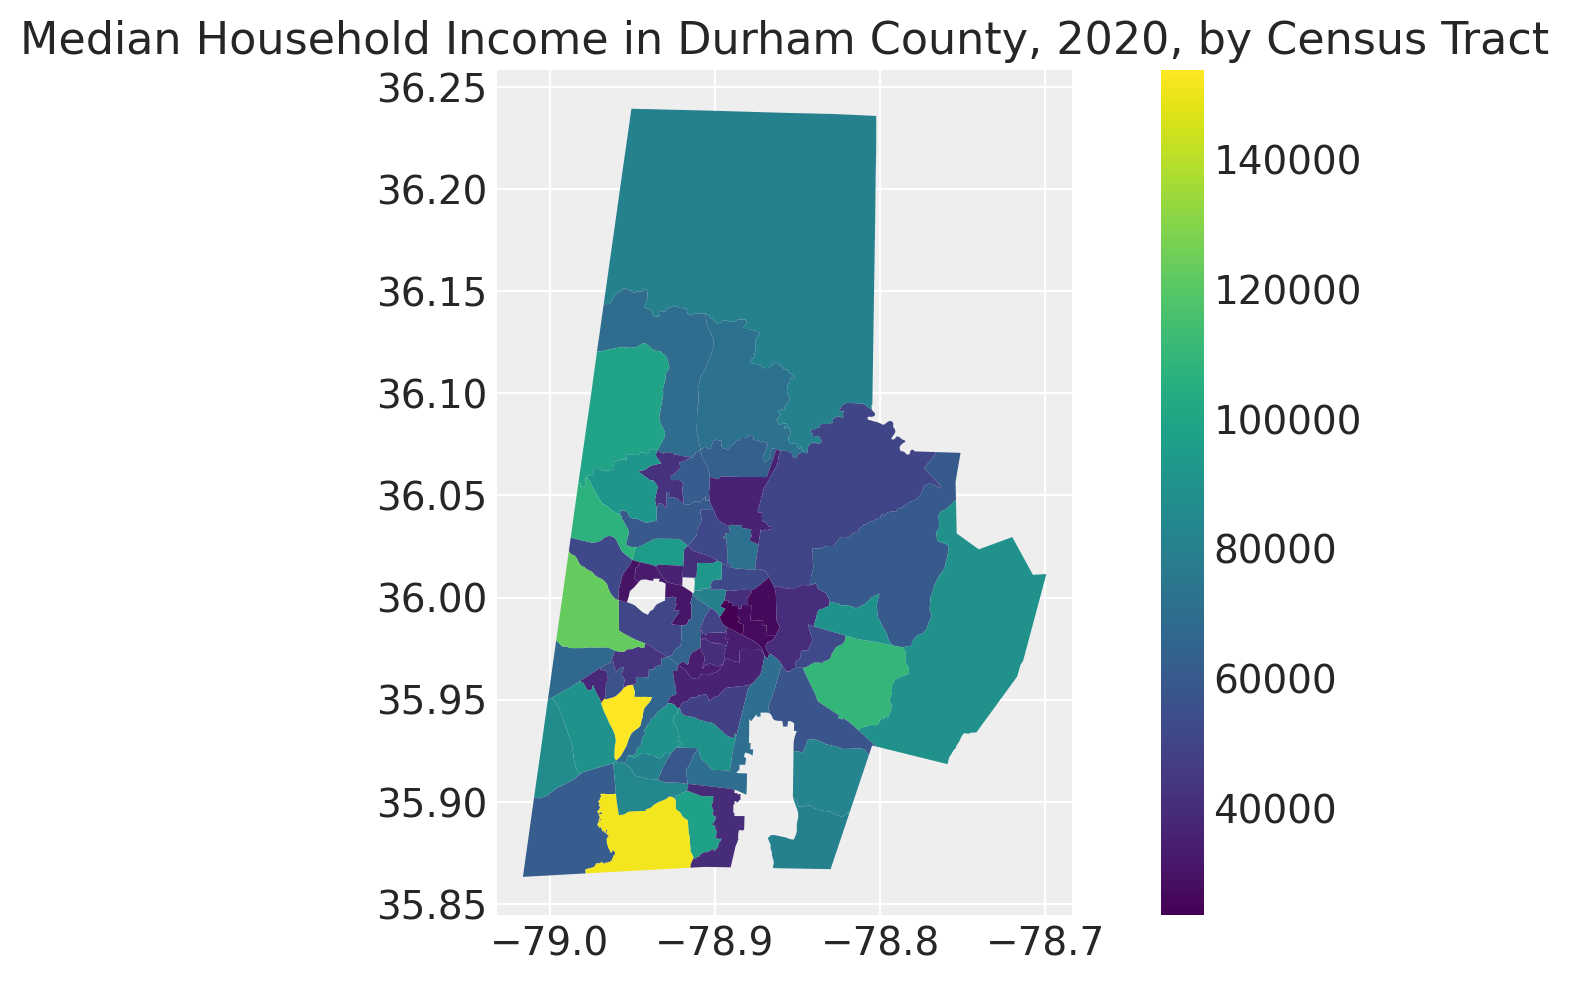

In [29]:
df.plot(column='income', legend=True)
plt.title("Median Household Income in Durham County, 2020, by Census Tract")

# Now, let's merge the station data with this data

In [31]:
# Read in the station data
stations = pd.read_csv('../data/raw/temperature/weather_underground/durham_stations.csv')
stations = stations[stations['qcStatus'] == 1]

/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_75648/3502034095.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k." (-> color='k'). The keyword argument will take precedence.
  plt.plot(stations['longitude'], stations['latitude'], 'k.', color='black', label='Station')


<Figure size 1000x1000 with 0 Axes>

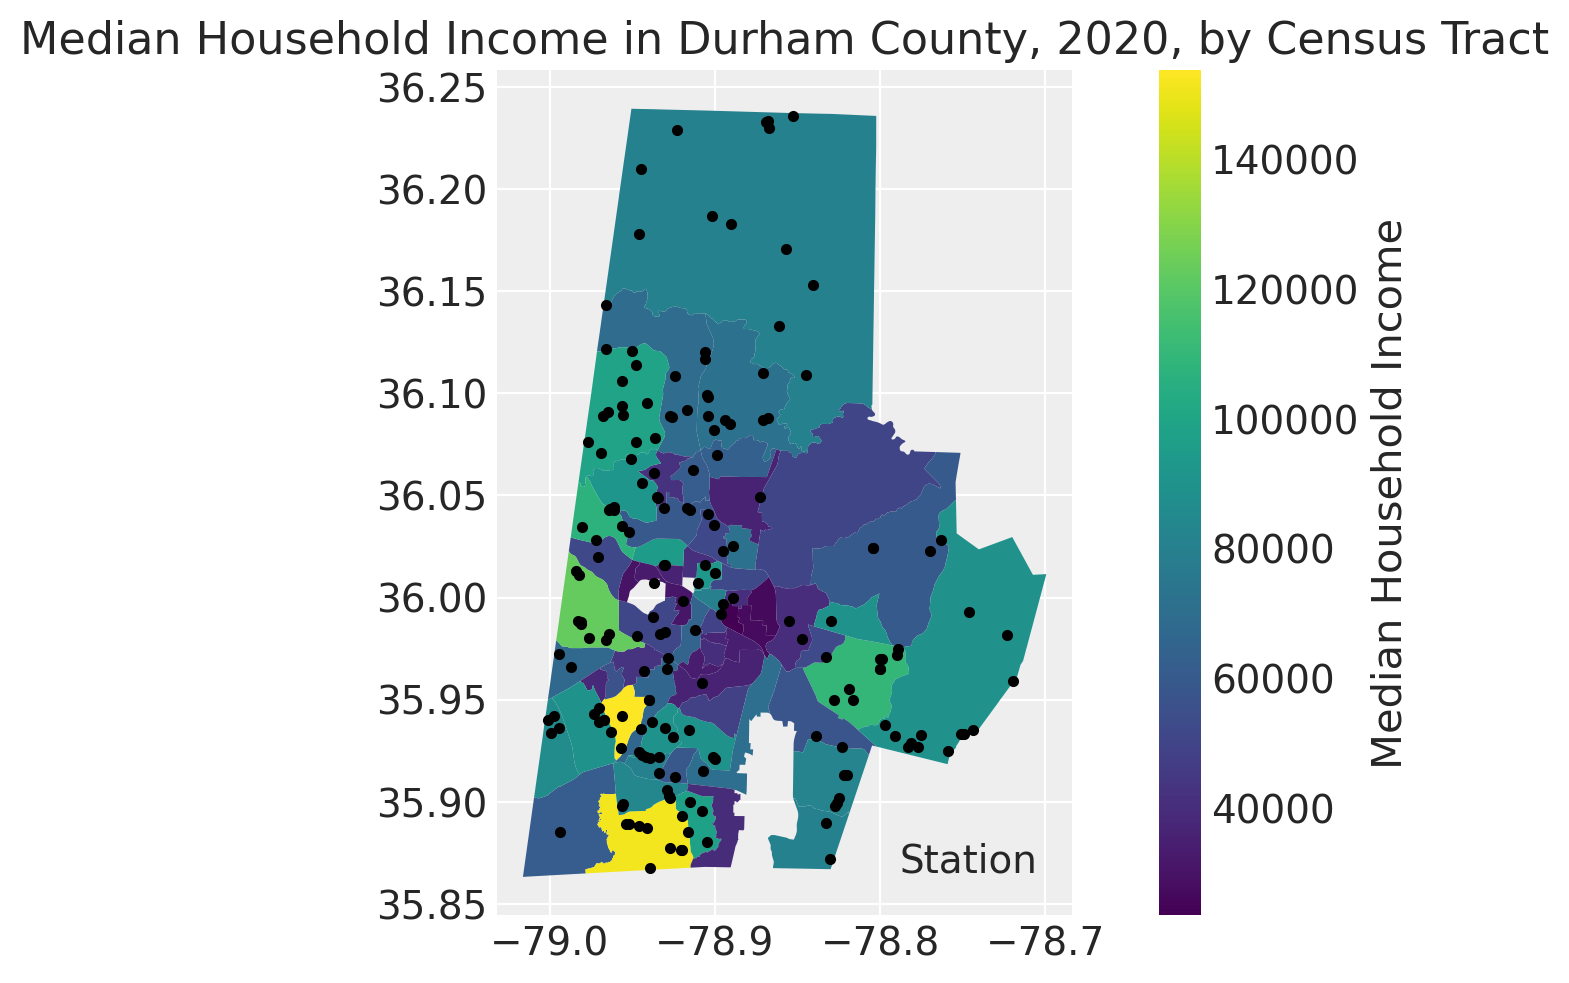

In [32]:
plt.figure(figsize=(10,10))
df.plot(column='income', legend=True, cmap='viridis', legend_kwds={
    "label": "Median Household Income"
})
plt.title("Median Household Income in Durham County, 2020, by Census Tract")
plt.plot(stations['longitude'], stations['latitude'], 'k.', color='black', label='Station')
plt.legend()
plt.show()

In [105]:


num_stations = []
income = []
aland = []
population = []
geometry = []
for i, row in df.iterrows():
    count = 0
    for j, s in stations.iterrows():
        # Check if station is in polygon
        p = Point(s['longitude'], s['latitude'])
        if row.geometry.contains(p):
            count += 1
    num_stations.append(count)

    income.append(row['income'])
    aland.append(row['area'])
    population.append(row['population'])
    geometry.append(row['geometry'])

In [106]:
assert len(income) == len(aland) == len(num_stations) == len(population)

In [136]:
count_data = pd.DataFrame({
    "num_stations": num_stations,
    "income": income,
    "area": aland,
    "population": population,
    "geometry": geometry
})

In [108]:
count_data.head()

,num_stations,income,area,population
0,1,72382.0,3370322,3716
1,3,51488.0,3998235,3702
2,0,52375.0,3021171,3309
3,0,41750.0,1586355,2826
4,3,92500.0,1722150,3515


In [116]:
count_data['num_stations'].values

array([ 1,  3,  0,  0,  3,  2,  0,  1,  4,  1,  1,  0,  0,  1,  0,  0,  0,
        0,  1,  0,  0,  0,  9,  8, 12,  4,  1,  1,  1,  1,  3,  4,  5,  0,
        2,  3,  9,  2,  1,  1, 13,  3,  4,  1,  3,  1,  1, 11,  4,  1,  4,
        5,  3,  0,  2,  8,  0,  0,  4,  6,  1,  0,  1,  5, 13,  1,  0,  0])

In [117]:
len(count_data)

68

# Finally, the data is here
This data set has four columns: num_stations, income, area, and population. Together, we can create a model to look at the effect of income on the intensity.

But first, we should verify to what extent normalization is required.

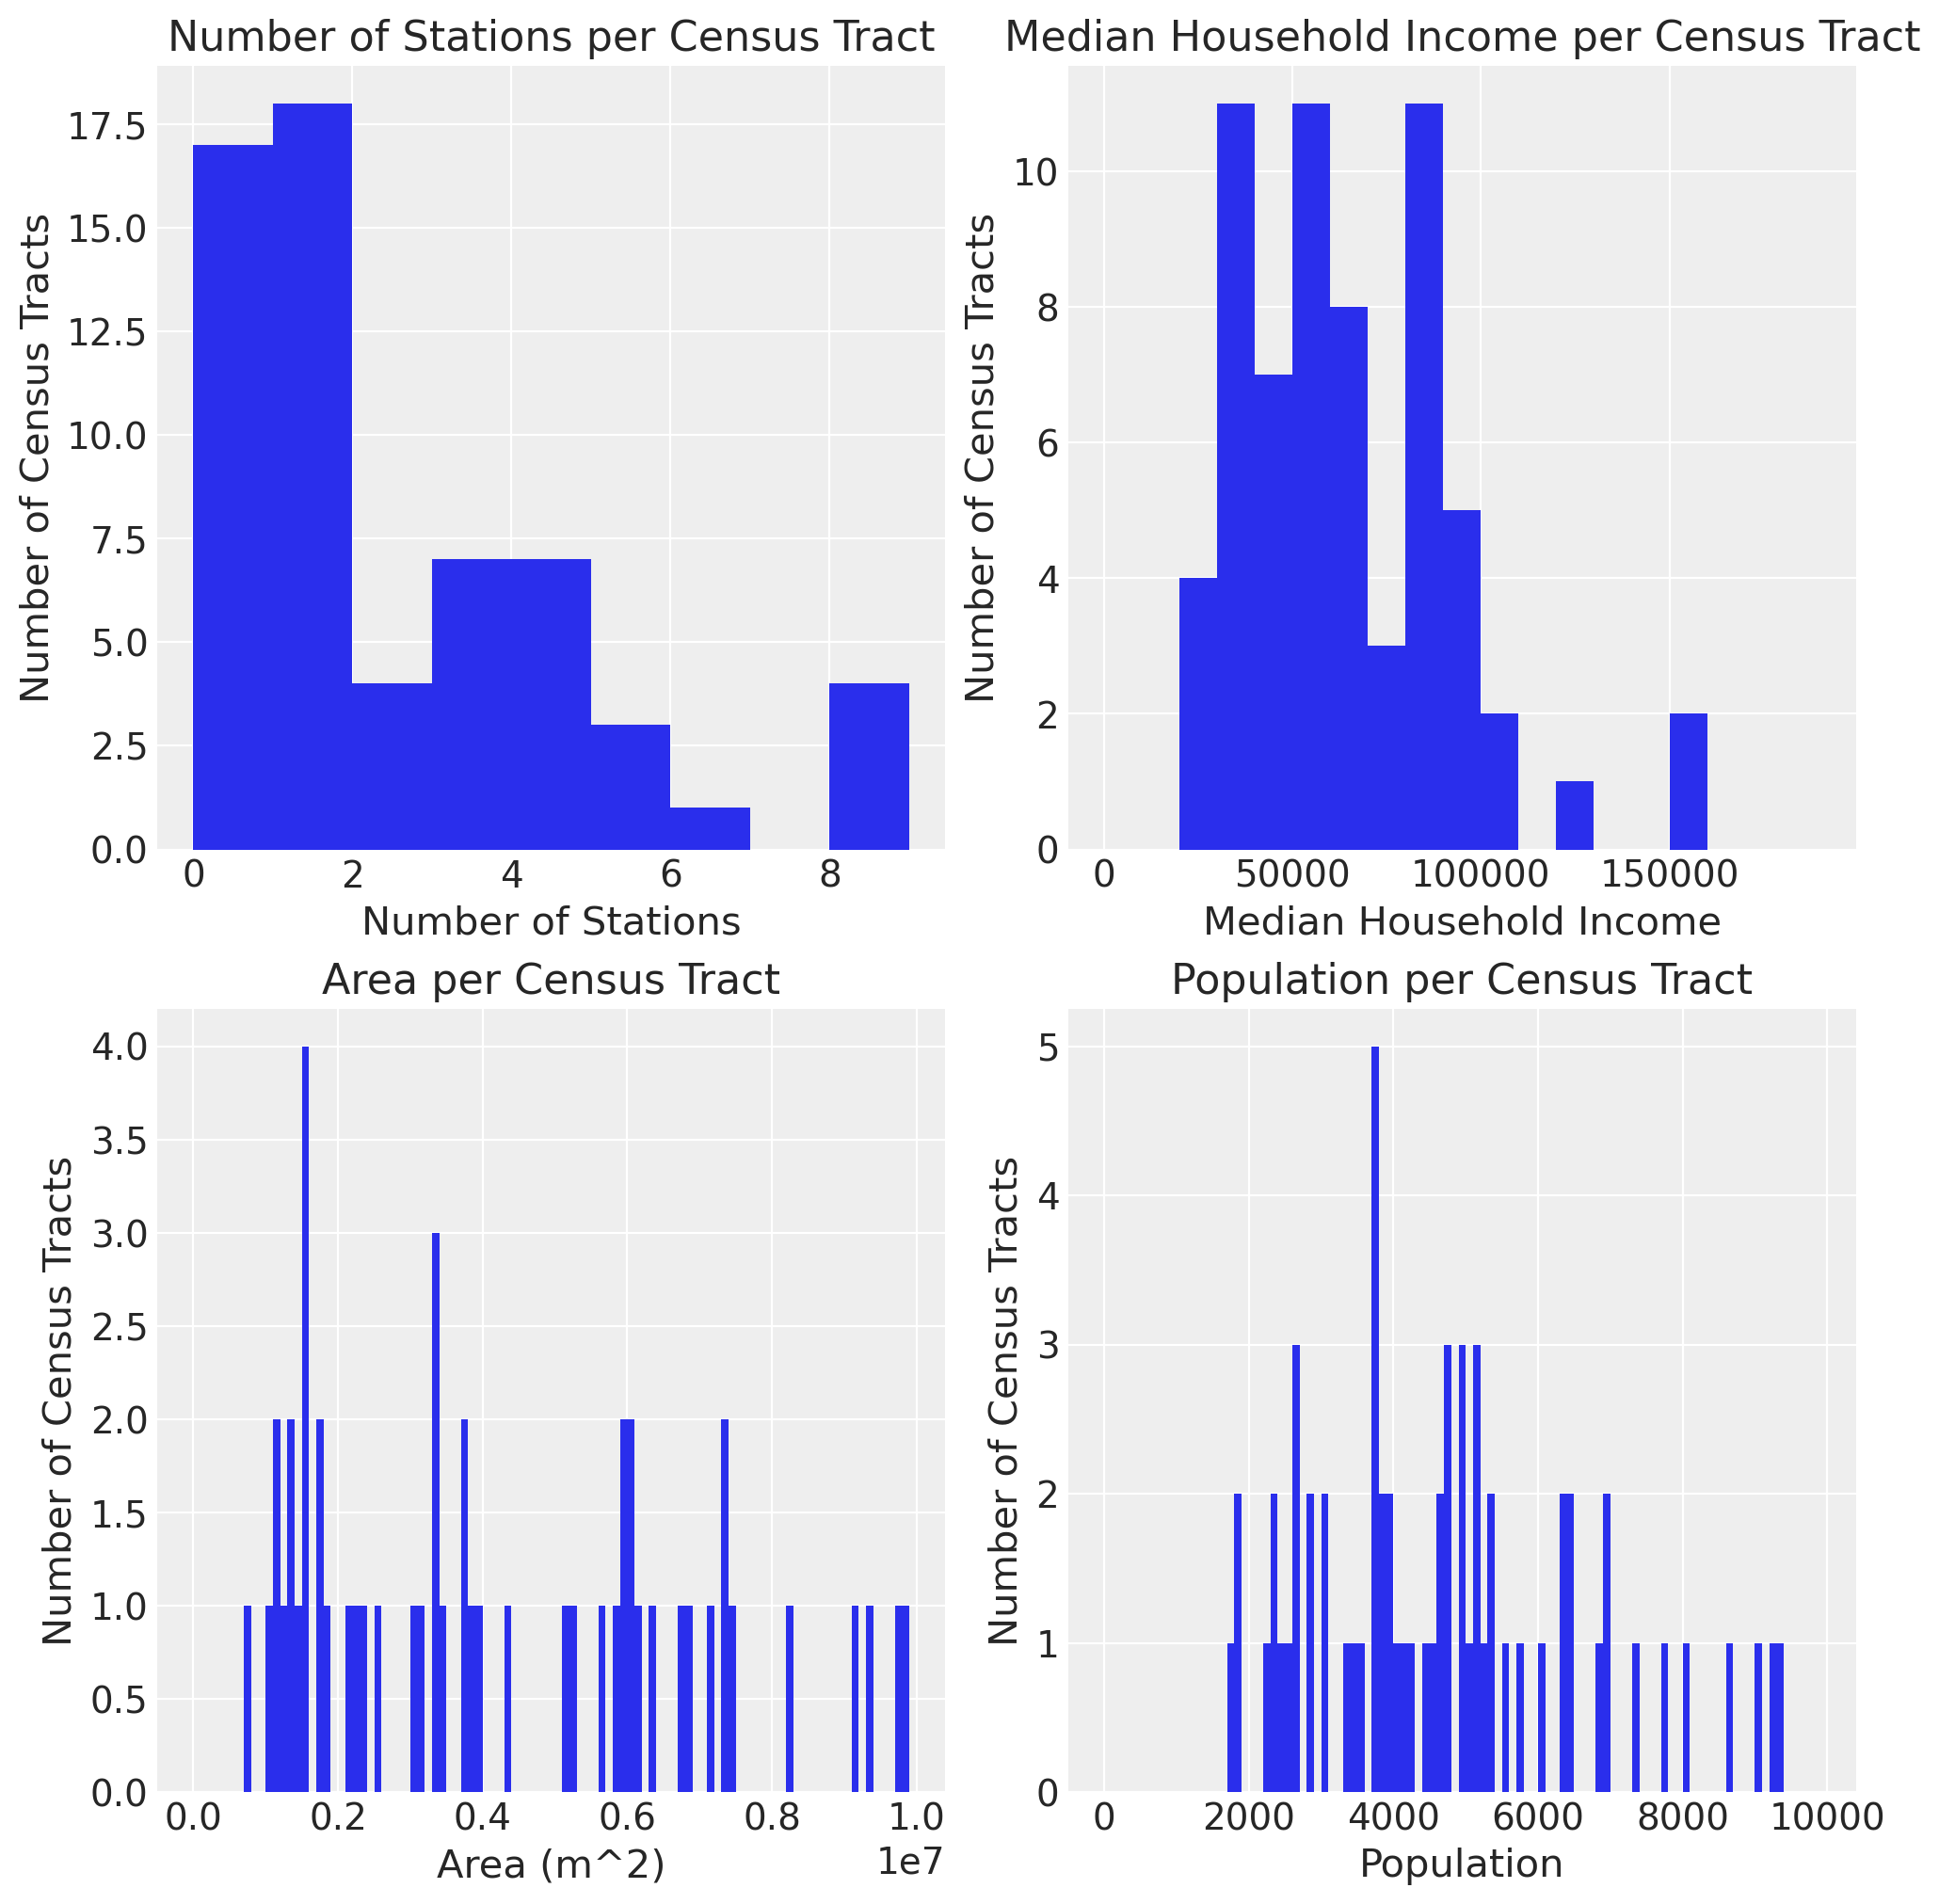

In [17]:
plt.subplots(2,2, figsize=(10,10))
plt.subplot(2,2,1)
plt.hist(count_data['num_stations'], bins=range(0,10))
plt.xlabel("Number of Stations")
plt.ylabel("Number of Census Tracts")
plt.title("Number of Stations per Census Tract")

plt.subplot(2,2,2)
plt.hist(count_data['income'], bins=range(0,200000,10000))
plt.xlabel("Median Household Income")
plt.ylabel("Number of Census Tracts")
plt.title("Median Household Income per Census Tract")

plt.subplot(2,2,3)
plt.hist(count_data['area'], bins=range(0,10000000,100000))
plt.xlabel("Area (m^2)")
plt.ylabel("Number of Census Tracts")
plt.title("Area per Census Tract")

plt.subplot(2,2,4)
plt.hist(count_data['population'], bins=range(0,10000,100))
plt.xlabel("Population")
plt.ylabel("Number of Census Tracts")
plt.title("Population per Census Tract")

plt.show()


Are there any weird values?

In [137]:
# Are there missing values?
print(sum(count_data['income'].isna()))

# Is there a place with no population?
print(sum(count_data['population'] == 0))

3
1


In [138]:
count_data['num_stations'][count_data['income'].isna()]

18    1
19    0
67    0
Name: num_stations, dtype: int64

Ok, so there is one census tract with zero people, and three with no income data...these are all affiliated with Duke University or research triangle park. 

My thinking is that we remove the census tract with zero population, and then we get the spatial mean temperature for the remaining census tracts (just get the average of all of the incomes surrounding that location).

Alternatively, we could completely remove these communities from the map, but I think that is in poor form for this kind of analysis.

In [139]:
# Remove the row with no population
count_data = count_data[count_data['population'] != 0]
print(len(count_data))

67


In [140]:
no_income_mask = count_data[count_data['income'].isna()]

In [141]:
count_data.head()

,num_stations,income,area,population,geometry
0,1,72382.0,3370322,3716,"POLYGON ((-78.894894 36.029906, -78.8934309999..."
1,3,51488.0,3998235,3702,"POLYGON ((-78.916547 36.02532, -78.916352 36.0..."
2,0,52375.0,3021171,3309,"POLYGON ((-78.90299399999999 36.005742, -78.90..."
3,0,41750.0,1586355,2826,"POLYGON ((-78.919568 36.010432, -78.919489 36...."
4,3,92500.0,1722150,3515,"POLYGON ((-78.912461 36.003958, -78.912427 36...."


In [142]:

no_income_mask

,num_stations,income,area,population,geometry
18,1,NaN,2738792,3498,"POLYGON ((-78.95315 35.998132999999996, -78.95..."
19,0,NaN,449529,1923,"POLYGON ((-78.91982 36.005942999999995, -78.91..."


In [143]:
import libpysal
from libpysal.weights import Rook

w = Rook.from_dataframe(count_data)

for no_income in no_income_mask.index:
    neighbors = w.neighbors[no_income]
    print(neighbors)
    print(count_data['income'][neighbors])
    no_income_neighbors = count_data['income'].values[neighbors].mean()

    count_data.loc[no_income, 'income'] = no_income_neighbors

[8, 20, 21, 7]
8     50972.0
20    29652.0
21    32877.0
7     30645.0
Name: income, dtype: float64
[65, 3, 4, 6, 7]
65    79917.0
3     41750.0
4     92500.0
6     35926.0
7     30645.0
Name: income, dtype: float64


/var/folders/3r/mm1k6hx10zlgnb46j7vtvxz80000gq/T/ipykernel_75648/3940928076.py:4: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Rook.from_dataframe(count_data)


In [173]:
count_data.head()

,num_stations,income,area,population,geometry
0,1,72382.0,3370322,3716,"POLYGON ((-78.894894 36.029906, -78.8934309999..."
1,3,51488.0,3998235,3702,"POLYGON ((-78.916547 36.02532, -78.916352 36.0..."
2,0,52375.0,3021171,3309,"POLYGON ((-78.90299399999999 36.005742, -78.90..."
3,0,41750.0,1586355,2826,"POLYGON ((-78.919568 36.010432, -78.919489 36...."
4,3,92500.0,1722150,3515,"POLYGON ((-78.912461 36.003958, -78.912427 36...."


In [59]:
# Remove the row with no population
count_data = count_data[count_data['population'] != 0]

# When income is missing, set it to the mean
count_data['income'] = count_data['income'].fillna(count_data['income'].mean())

In [151]:
count_data.iloc[19]

num_stations                                                    0
income                                                    56147.6
area                                                       449529
population                                                   1923
geometry        POLYGON ((-78.91982 36.005942999999995, -78.91...
Name: 19, dtype: object

In [74]:
print(len(count_data))

67


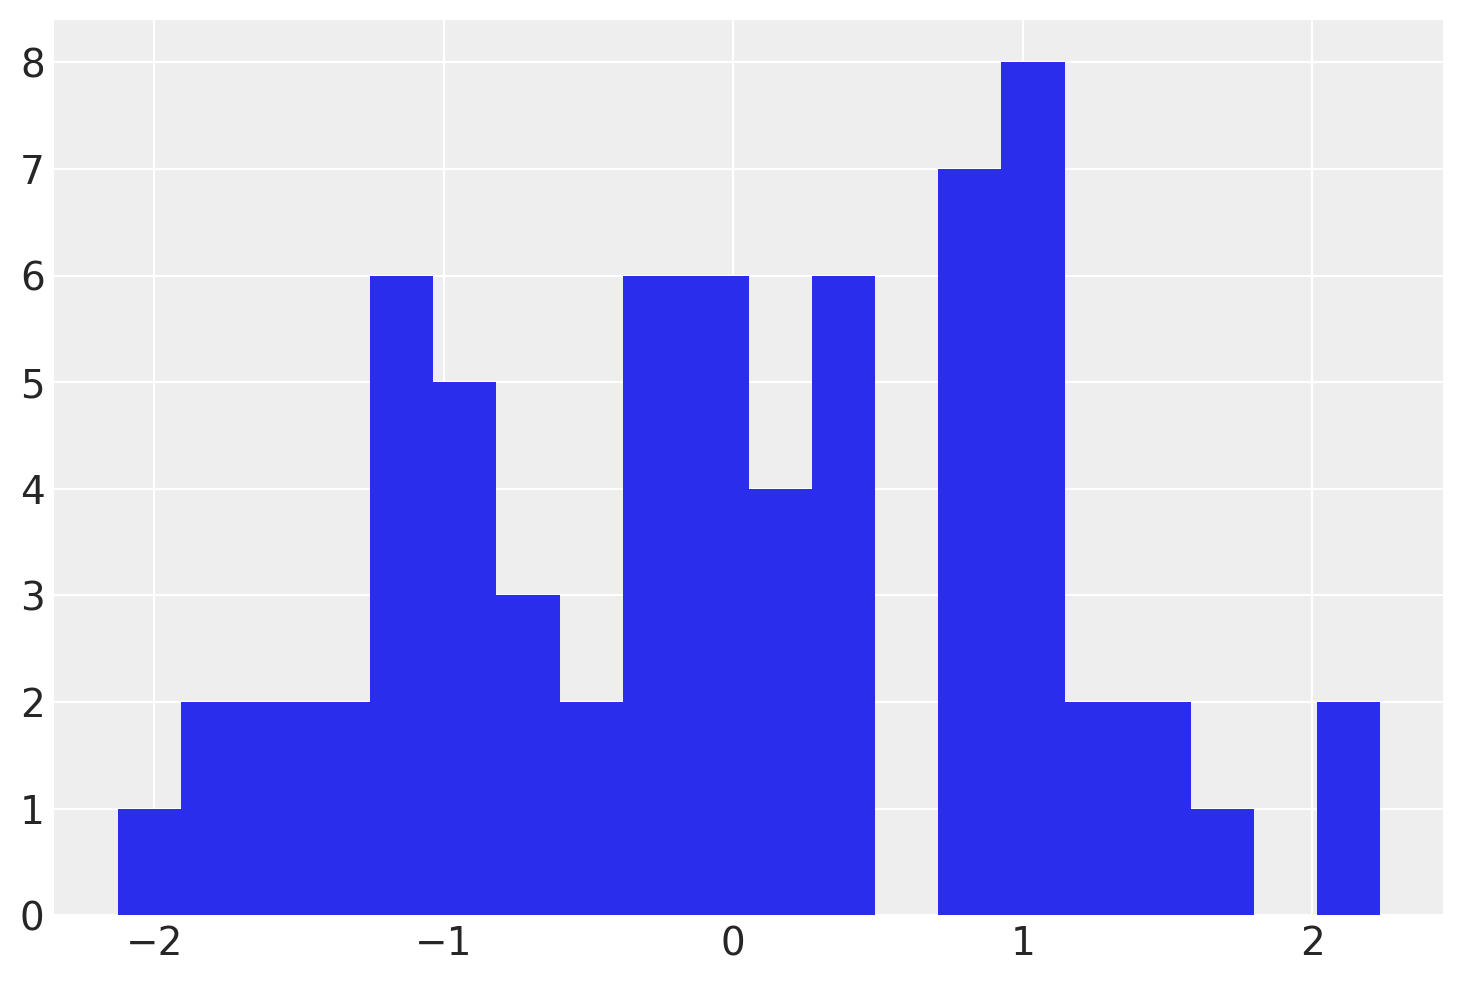

In [153]:
# Let's just normalize income
# mask = count_data['income'].isna()
log_income = np.log(count_data['income'].values)
# Turn this into a masked array with nan values turned to masks
# log_income = np.ma.masked_invalid(log_income)
# log_income = np.log(count_data['income'].values)
log_income_std = (log_income - np.mean(log_income)) / np.std(log_income)
plt.hist(log_income_std, bins=20)
plt.show()

This looks like a reasonable normalization for income -- although I don't think this is going to matter too much. The important thing is that the data is standardized around the mean.

To make our data in reasonable units, let's convert area to be in square KM and population in 1000 people.

In [154]:
area = count_data['area'].values / 1e6
population = count_data['population'].values / 1e3
num_stations = count_data['num_stations'].values

# Looking at intensity, normalized by area

In [155]:

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100)
    log_intensity = alpha + beta * log_income_std
    intensity = pm.math.exp(log_intensity)

    rates = intensity * area

    counts = pm.Poisson('counts', mu=rates, observed=num_stations)

In [156]:
with model:
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

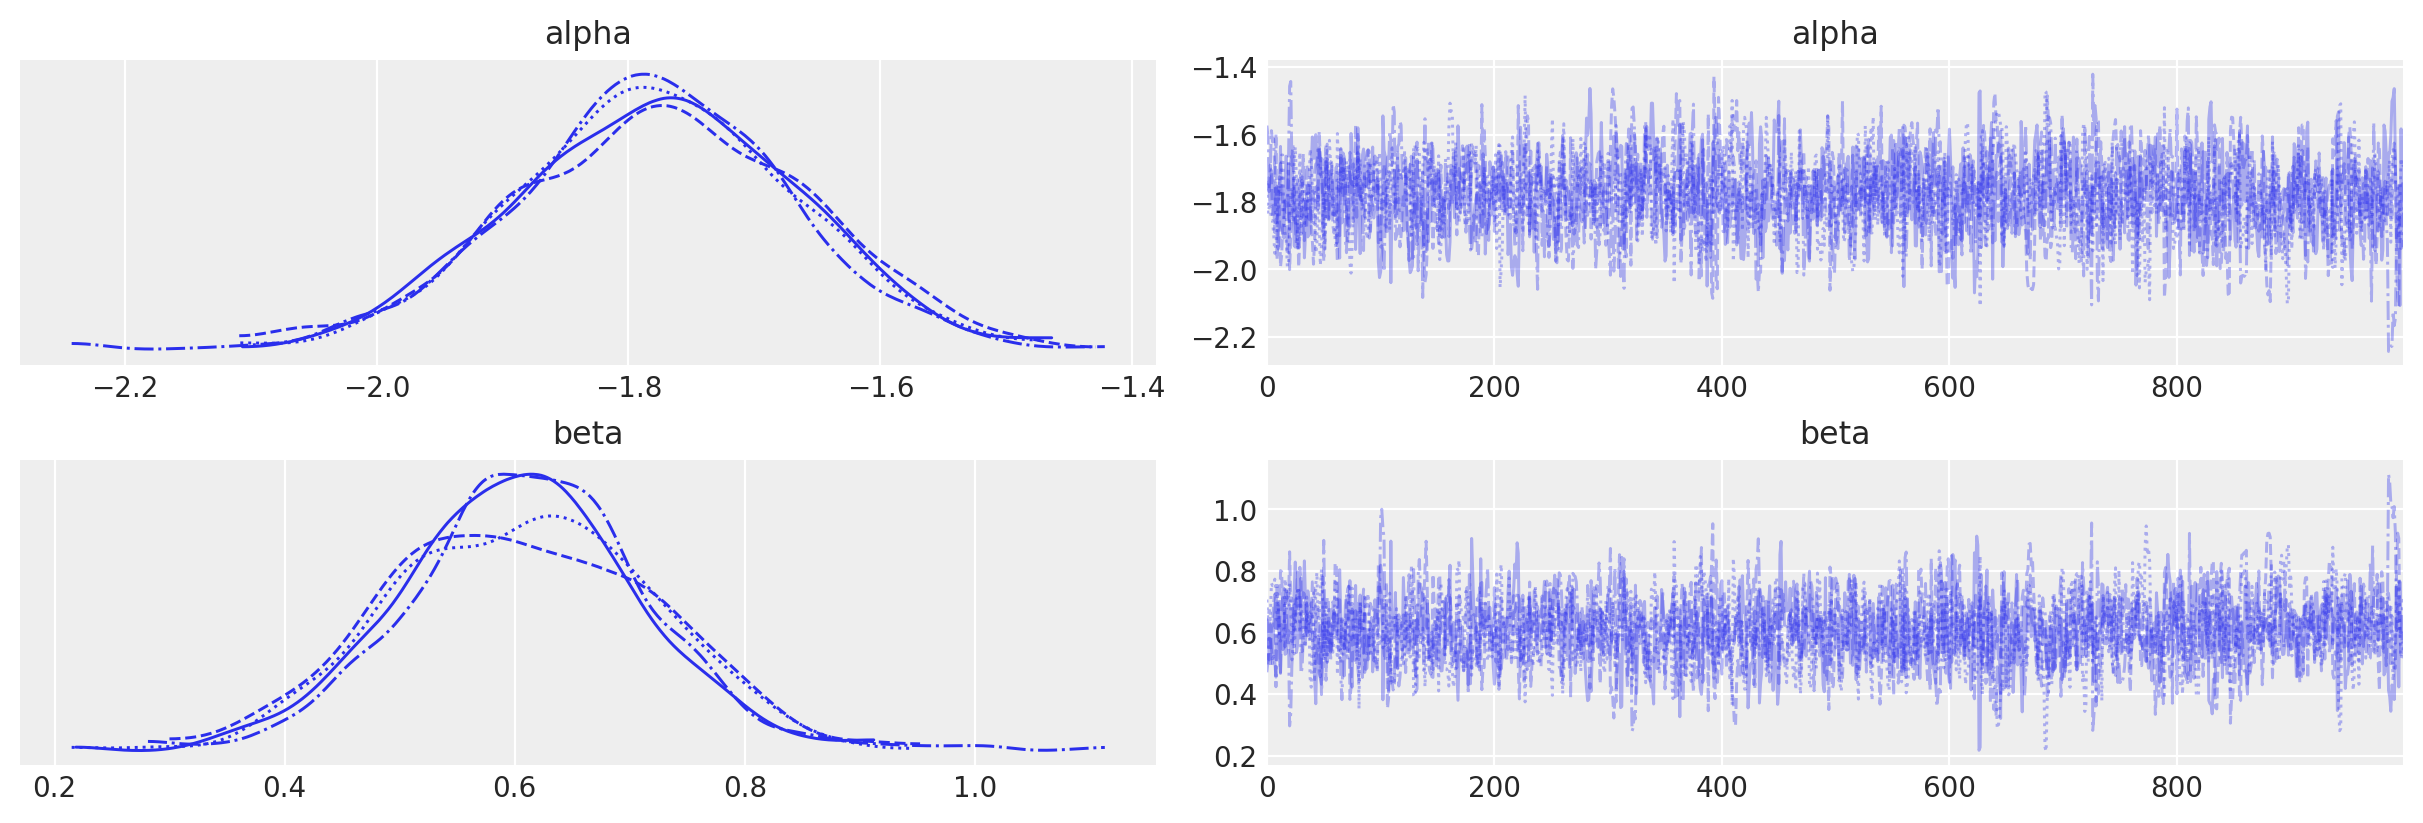

In [157]:
import arviz as az

az.plot_trace(trace)

In [158]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-1.779,0.113,-1.982,-1.56,0.003,0.002,1605.0,1742.0,1.00
beta,0.607,0.110,0.394,0.80,0.003,0.002,1662.0,1463.0,1.01


Text(0, 0.5, 'Intensity (stations / km^2)')

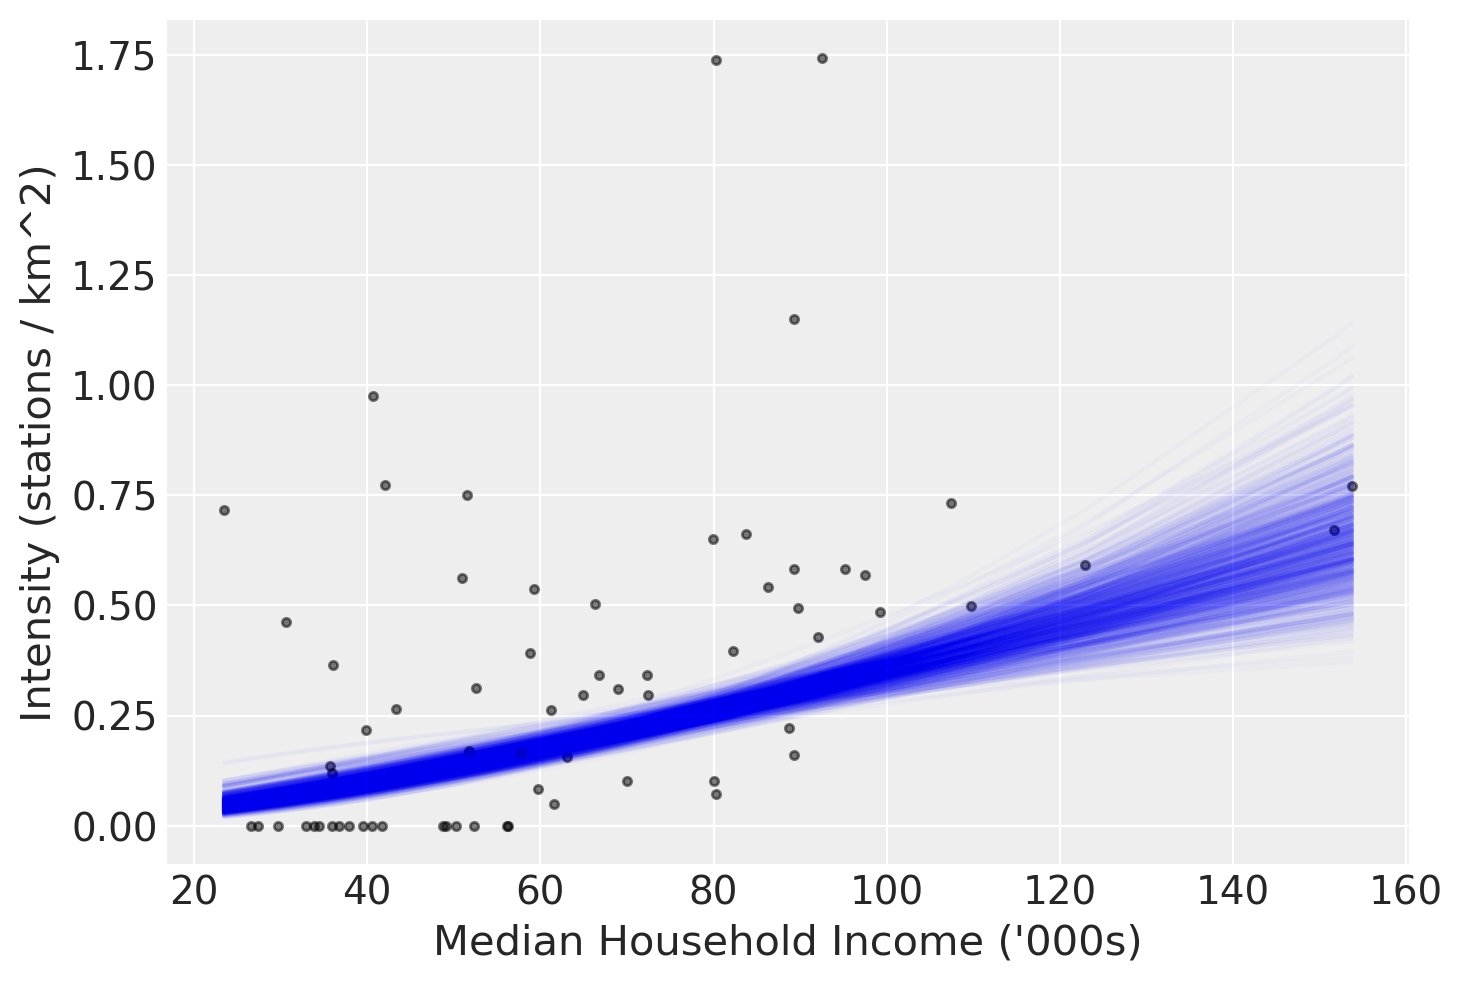

In [160]:
order = np.argsort(log_income_std)
log_income_sorted = log_income_std[order]
income_sorted = np.array(count_data['income'])[order]

# Unormalize income sorted


plt.plot(income_sorted/1000, num_stations[order] / area[order], 'k.', alpha=0.5)

# plot the posterior predictive sample
alpha = trace.posterior['alpha'].values.flatten()
beta = trace.posterior['beta'].values.flatten()
for i in range(1000):
    plt.plot(income_sorted/1000, np.exp(alpha[i] + beta[i] * log_income_sorted), 'b-', alpha=0.02)

plt.xlabel("Median Household Income ('000s)")
plt.ylabel("Intensity (stations / km^2)")


# Now, let's do the same thing, looking at stations per 1000 people

In [161]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sigma=100)
    beta = pm.Normal('beta', mu=0, sigma=100)
    log_intensity = alpha + beta * log_income_std
    intensity = pm.math.exp(log_intensity)

    rates = intensity * population

    counts = pm.Poisson('counts', mu=rates, observed=num_stations)

In [162]:
with model:
    trace = pm.sample(1000, tune=1000, chains=4, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

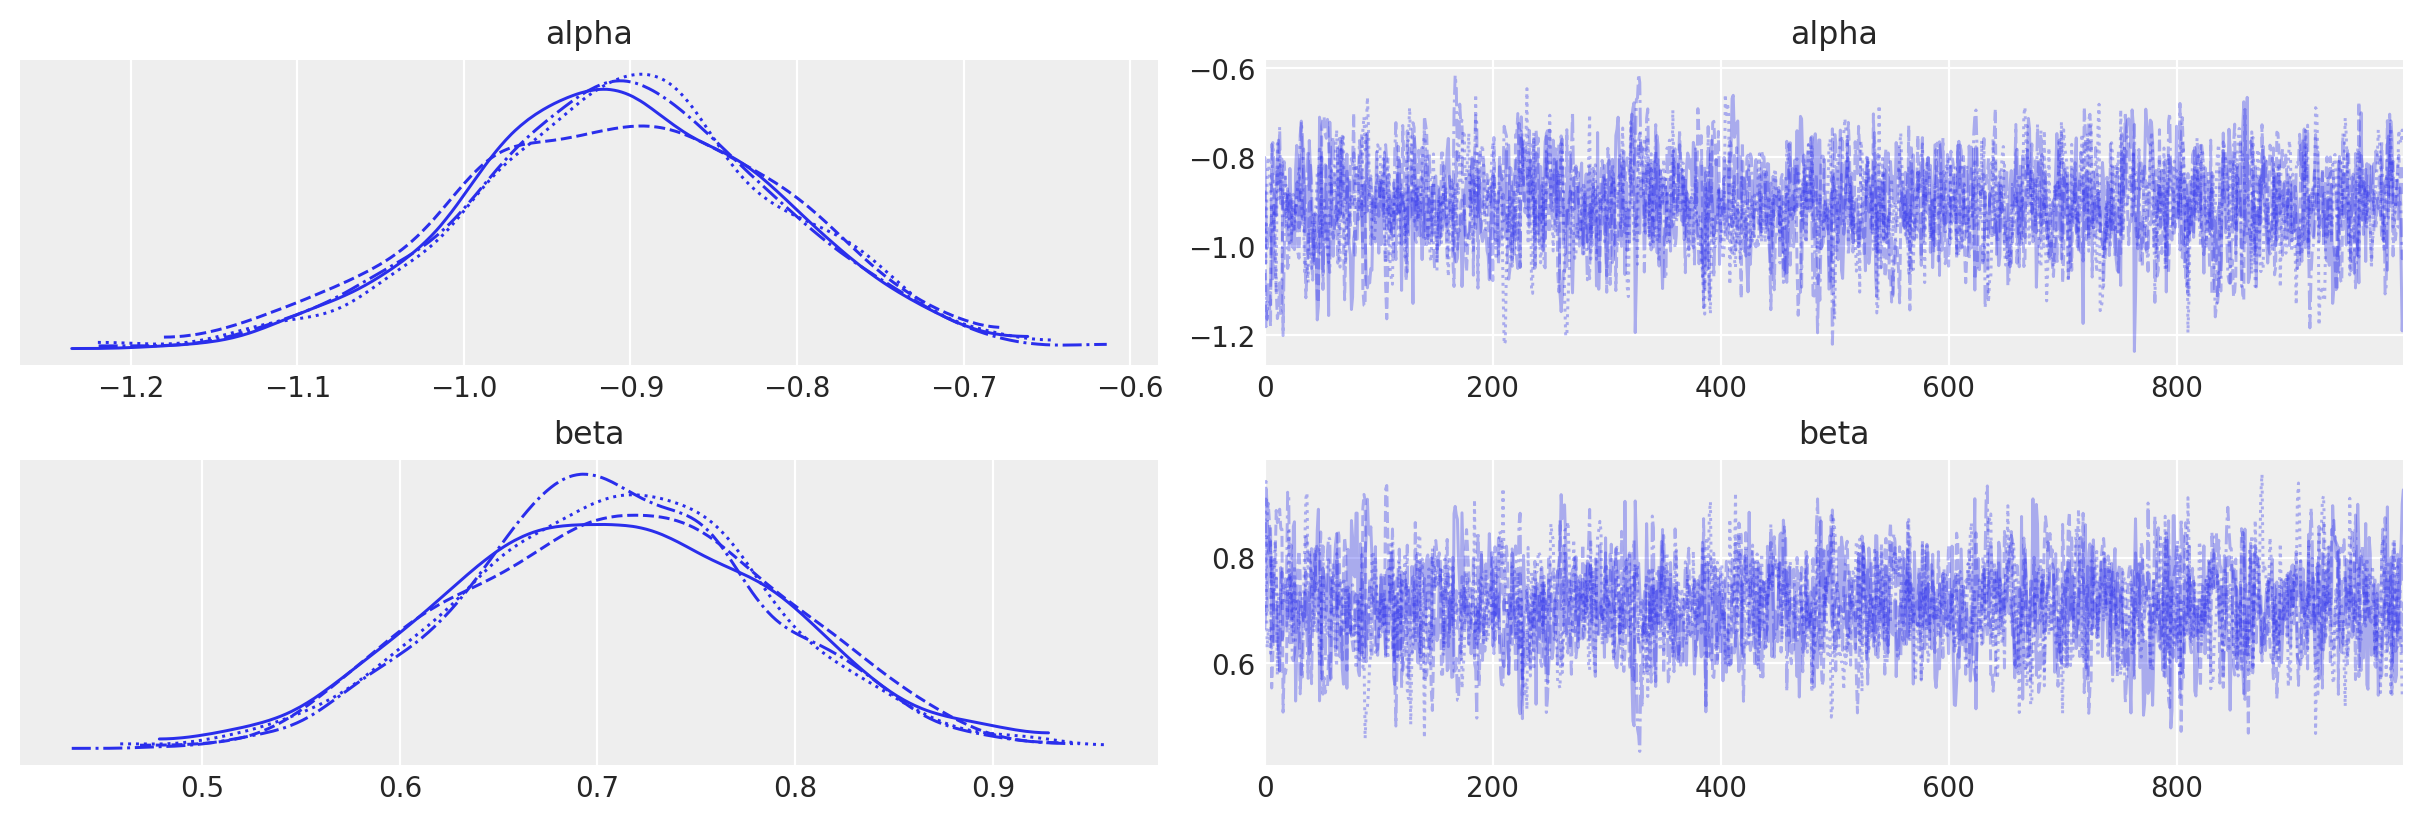

In [163]:
import arviz as az

az.plot_trace(trace)

In [164]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.907,0.095,-1.096,-0.735,0.002,0.002,1586.0,1883.0,1.0
beta,0.708,0.080,0.558,0.855,0.002,0.001,1640.0,2000.0,1.0


Text(0, 0.5, 'Intensity (stations / 1000 people)')

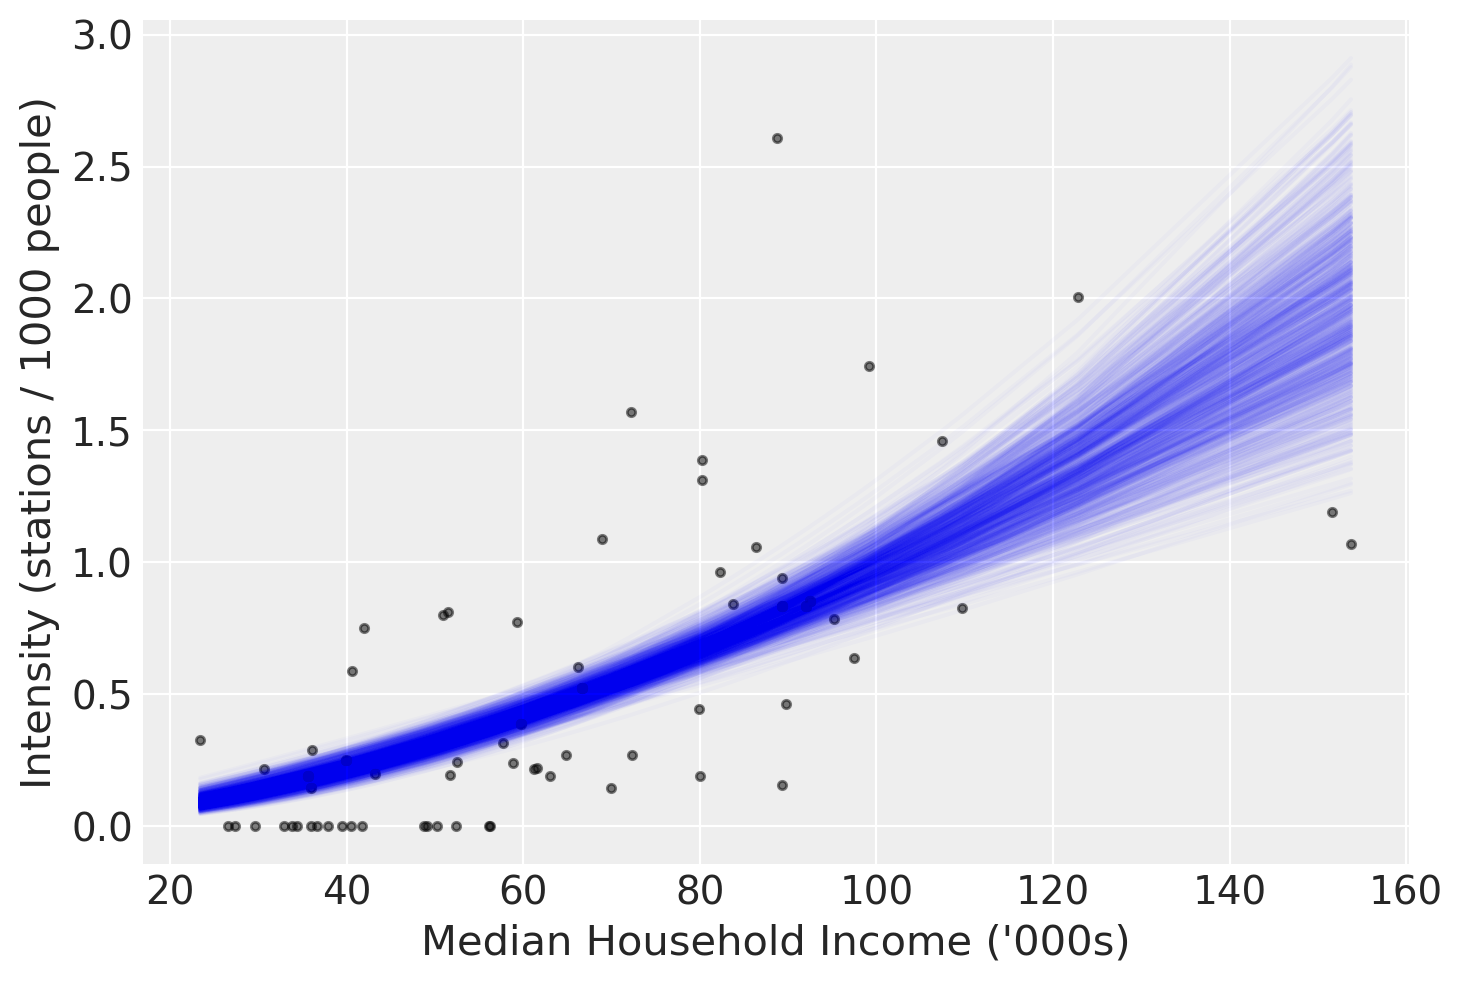

In [165]:
order = np.argsort(log_income_std)
log_income_sorted = log_income_std[order]
income_sorted = np.array(count_data['income'])[order]

# Unormalize income sorted


plt.plot(income_sorted/1000, num_stations[order] / population[order], 'k.', alpha=0.5)

# plot the posterior predictive sample
alpha = trace.posterior['alpha'].values.flatten()
beta = trace.posterior['beta'].values.flatten()
for i in range(1000):
    plt.plot(income_sorted/1000, np.exp(alpha[i] + beta[i] * log_income_sorted), 'b-', alpha=0.02)

plt.xlabel("Median Household Income ('000s)")
plt.ylabel("Intensity (stations / 1000 people)")

In [166]:
alpha = trace.posterior['alpha'].values.flatten()
beta = trace.posterior['beta'].values.flatten()

intensity = np.exp(alpha.mean() + beta.mean() * log_income_std)

In [170]:
df = df[df['population'] != 0]
df['intensity'] = intensity

/Users/zdc6/mambaforge/envs/pspws/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

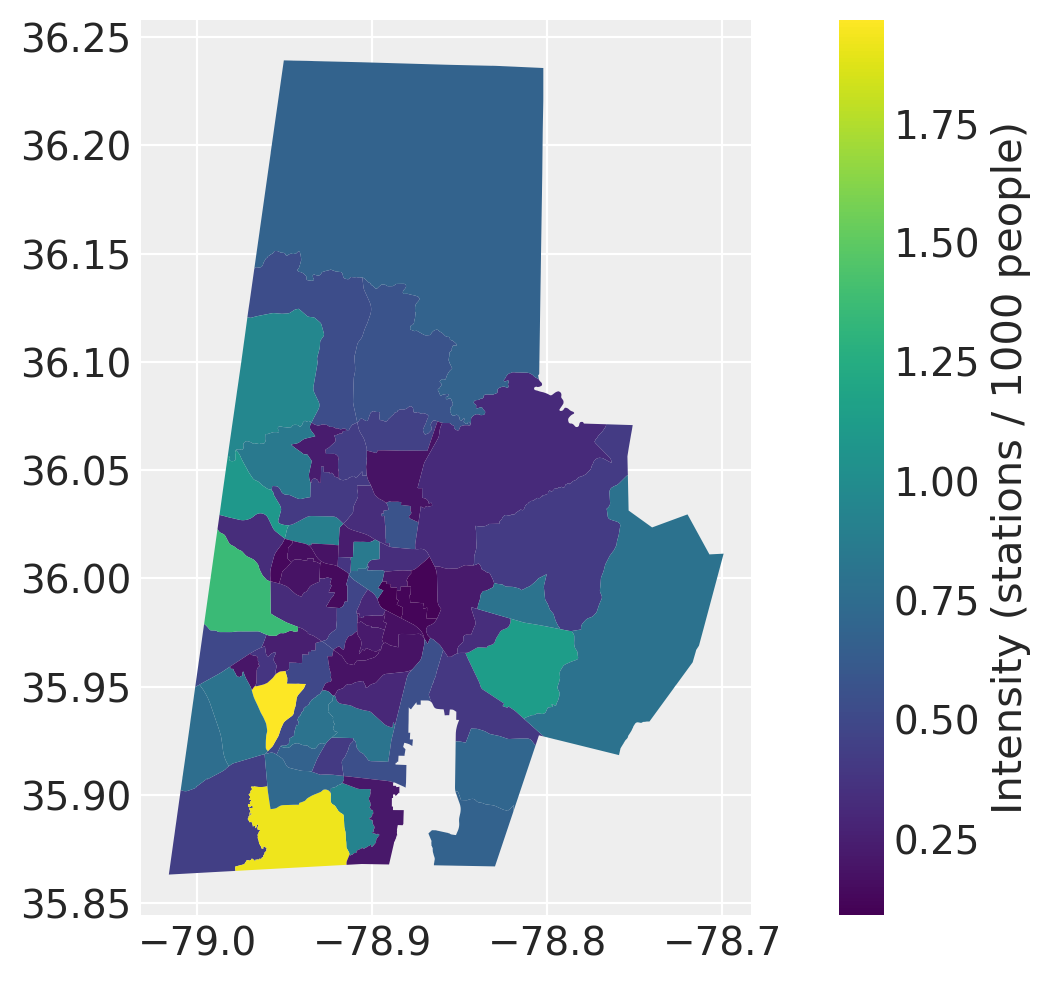

In [171]:
# plt.subplots(1,2)
# plt.subplot(2,1,1)
df.plot(column='intensity', legend=True, cmap='viridis', legend_kwds={
    "label": "Intensity (stations / 1000 people)"
})


<Axes: >

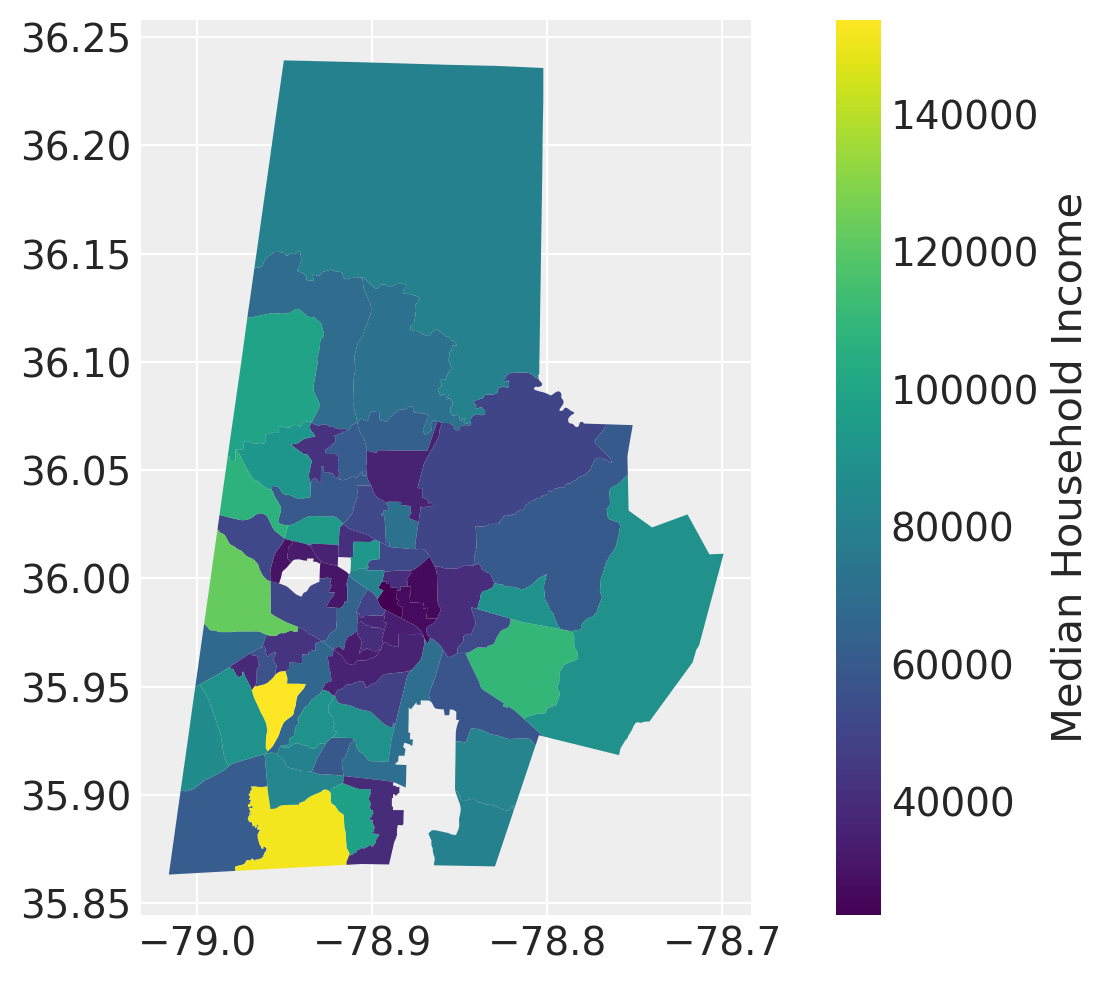

In [172]:

df.plot(column='income', legend=True, cmap='viridis', legend_kwds={
    "label": "Median Household Income"
})